In [ ]:
# Orignal Dataset - German Dataset is not included
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as L, models as M, callbacks as C, optimizers as O
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc

In [8]:
# =========================
#           PATHS
# =========================
# Each of these is a TOP-LEVEL folder that contains 4–5 (or more) subfolders of .npy files.
DRONE_ROOT   = r"/home/destrox-907/Husnian_FYP/Dataset/MFCC Drone Dataset/MFCC Drone Dataset"
NODRONE_ROOT = r"/home/destrox-907/Husnian_FYP/Dataset/MFCC Noise Dataset/MFCC Noise Dataset"

# =========================
#      CONFIG / HYPERS
# =========================
INPUT_SHAPE     = (13, 40, 1)
BATCH_SIZE      = 128
EPOCHS          = 40
LEARNING_RATE   = 1e-3
MIXUP_ALPHA     = 0.3      # set 0.0 to disable
USE_SPECAUG     = True
VAL_SIZE        = 0.20
SEED            = 42

In [9]:
# =========================
#  RECURSIVE DATA LOADING
# =========================
def collect_npy_paths(root_dir):
    paths = []
    for r, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(".npy"):
                paths.append(os.path.join(r, f))
    return paths

def load_paths_and_labels(drone_root, nodrone_root):
    drone_paths   = collect_npy_paths(drone_root)
    nodrone_paths = collect_npy_paths(nodrone_root)
    paths  = np.array(drone_paths + nodrone_paths)
    labels = np.array([1]*len(drone_paths) + [0]*len(nodrone_paths), dtype=np.int32)
    return paths, labels

paths, labels = load_paths_and_labels(DRONE_ROOT, NODRONE_ROOT)
print(f"Total .npy files: {len(paths)} | drone={labels.sum()} | no_drone={len(labels)-labels.sum()}")

# Stratified split (replace with grouped split later if you want “unseen drone models” eval)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    paths, labels, test_size=VAL_SIZE, random_state=SEED, stratify=labels
)

Total .npy files: 311836 | drone=189207 | no_drone=122629


In [10]:
# =========================
#     DATA PIPELINE
# =========================
def npy_loader(path):
    try:
        arr = np.load(path.decode("utf-8")).astype("float32")
        # Force correct shape (13,40,1)
        arr = np.reshape(arr, (13, 40, 1))
        return arr
    except Exception as e:
        print(f"[WARN] Failed to load {path.decode('utf-8')}: {e}")
        # return a dummy all-zeros MFCC (will not harm training much)
        return np.zeros((13, 40, 1), dtype="float32")


def tf_load(path, label, training=True):
    x = tf.numpy_function(npy_loader, [path], Tout=tf.float32)
    x = tf.ensure_shape(x, INPUT_SHAPE)

    if training and USE_SPECAUG:
        def _specaug(a):
            a = a.copy()
            f_dim, t_dim, _ = a.shape  # 13,40,1
            # freq masks (light)
            for _ in range(2):
                f = np.random.randint(0, 3+1)
                f0 = np.random.randint(0, max(1, f_dim - f + 1))
                a[f0:f0+f, :, :] = 0.0
            # time masks (light)
            for _ in range(2):
                t = np.random.randint(0, 6+1)
                t0 = np.random.randint(0, max(1, t_dim - t + 1))
                a[:, t0:t0+t, :] = 0.0
            return a
        x = tf.numpy_function(_specaug, [x], Tout=tf.float32)
        x = tf.ensure_shape(x, INPUT_SHAPE)

    y = tf.one_hot(label, 2)
    return x, y

def make_dataset(paths, labels, batch=BATCH_SIZE, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(8192, reshuffle_each_iteration=True)
    ds = ds.map(lambda p, l: tf_load(p, l, training=training),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch)

    # Optional MixUp
    if training and MIXUP_ALPHA > 0.0:
        def mixup_batch(x, y):
            lam = tf.random.uniform([], 0.5, 1.0)  # gentle mix
            idx = tf.random.shuffle(tf.range(tf.shape(x)[0]))
            x2 = tf.gather(x, idx); y2 = tf.gather(y, idx)
            return lam*x + (1-lam)*x2, lam*y + (1-lam)*y2
        ds = ds.map(mixup_batch, num_parallel_calls=tf.data.AUTOTUNE)

    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(X_train, y_train, training=True)
val_ds   = make_dataset(X_val,   y_val,   training=False)


In [11]:
# =========================
#   RESNET-LIKE BACKBONE
# =========================
def res_block(x, filters, stride=1):
    shortcut = x
    x = L.Conv2D(filters, (3,3), strides=stride, padding="same", use_bias=False)(x)
    x = L.BatchNormalization()(x); x = L.ReLU()(x)
    x = L.Conv2D(filters, (3,3), padding="same", use_bias=False)(x)
    x = L.BatchNormalization()(x)
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = L.Conv2D(filters, (1,1), strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = L.BatchNormalization()(shortcut)
    x = L.Add()([x, shortcut]); x = L.ReLU()(x)
    return x

def build_model(input_shape=(13,40,1), num_classes=2):
    inp = L.Input(shape=input_shape)
    x = L.Conv2D(32, (3,3), padding="same", use_bias=False)(inp)
    x = L.BatchNormalization()(x); x = L.ReLU()(x)

    x = res_block(x, 32)                 # 13x40
    x = res_block(x, 32)                 # 13x40
    x = L.MaxPool2D(pool_size=(1,2))(x)  # 13x20

    x = res_block(x, 64, stride=2)       # downsample
    x = res_block(x, 64)

    x = L.GlobalAveragePooling2D()(x)
    x = L.Dense(128, activation="relu")(x)
    x = L.Dropout(0.3)(x)
    out = L.Dense(num_classes, activation="softmax")(x)
    return M.Model(inp, out)

model = build_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 13, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 13, 40,    │        288 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 40,    │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 13, 40,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 13, 40,    │      9,216 │ re_lu_9[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 40,    │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 13, 40,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 13, 40,    │      9,216 │ re_lu_10[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 40,    │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 13, 40,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 13, 40,    │          0 │ add_4[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 13, 40,    │      9,216 │ re_lu_11[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 40,    │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 13, 40,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 13, 40,    │      9,216 │ re_lu_12[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 40,    │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 13, 40,    │          0 │ batch_normalizat

 Total params: 178,722 (698.13 KB)

 Trainable params: 177,762 (694.38 KB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
# =========================
#      TRAIN & EVAL
# =========================
opt = O.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

cbs = [
    C.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1),
    C.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    C.ModelCheckpoint("drone_resnet_best.keras", monitor="val_accuracy", save_best_only=True)
]


history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cbs)
# AUROC + best-F1 threshold
probs = model.predict(val_ds)[:, 1]
y_true = np.concatenate([y.numpy() for _, y in val_ds])[:, 1]
from sklearn.metrics import precision_recall_curve, auc, f1_score
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(y_true, probs)
prec, rec, thr = precision_recall_curve(y_true, probs)
auprc = auc(rec, prec)
cands = np.linspace(0.05, 0.95, 19)
f1s = [f1_score(y_true, (probs >= t).astype(int)) for t in cands]
best_thr, best_f1 = cands[int(np.argmax(f1s))], max(f1s)

Epoch 1/40


2025-09-10 08:15:47.452856: I external/local_xla/xla/service/service.cc:163] XLA service 0x78ff7401f570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-10 08:15:47.452870: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-10 08:15:47.452872: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-10 08:15:48.116636: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-10 08:15:48.522426: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-09-10 08:15:48.647602: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints

  16/1949 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.6939 - loss: 0.6809

I0000 00:00:1757474151.310316    6869 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1947/1949 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8791 - loss: 0.3826

2025-09-10 08:17:03.805739: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-10 08:17:03.805775: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-10 08:17:03.805781: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-10 08:17:04.086505: I external/l

1949/1949 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8791 - loss: 0.3826

2025-09-10 08:17:14.350938: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_297', 20 bytes spill stores, 20 bytes spill loads



1949/1949 ━━━━━━━━━━━━━━━━━━━━ 89s 43ms/step - accuracy: 0.8985 - loss: 0.3575 - val_accuracy: 0.9420 - val_loss: 0.1215 - learning_rate: 0.0010
Epoch 2/40
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 74s 38ms/step - accuracy: 0.9153 - loss: 0.3319 - val_accuracy: 0.9700 - val_loss: 0.0797 - learning_rate: 0.0010
Epoch 3/40
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 74s 38ms/step - accuracy: 0.9235 - loss: 0.3239 - val_accuracy: 0.9761 - val_loss: 0.0781 - learning_rate: 0.0010
Epoch 4/40
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 74s 38ms/step - accuracy: 0.9282 - loss: 0.3180 - val_accuracy: 0.9726 - val_loss: 0.0742 - learning_rate: 0.0010
Epoch 5/40
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 75s 38ms/step - accuracy: 0.9291 - loss: 0.3182 - val_accuracy: 0.9751 - val_loss: 0.0746 - learning_rate: 0.0010
Epoch 6/40
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 75s 39ms/step - accuracy: 0.9322 - loss: 0.3116 - val_accuracy: 0.9764 - val_loss: 0.0757 - learning_rate: 0.0010
Epoch 7/40
1949/1949 ━━━━━━━━━━━━━━━━━━━━ 75s 38ms/step - accuracy: 0.9309 

2025-09-10 08:40:04.280477: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
# --- SAVE THE FINAL MODEL (whatever weights are in memory now) ---
model.save("drone_resnet_orignal.keras")

In [14]:

print(f"\n=== Validation Metrics ===")
print(f"AUROC  : {auroc:.4f}")
print(f"AUPRC  : {auprc:.4f}")
print(f"Best F1: {best_f1:.4f} @ threshold={best_thr:.2f}")


=== Validation Metrics ===
AUROC  : 0.9990
AUPRC  : 0.9995
Best F1: 0.9920 @ threshold=0.50


Confusion Matrix (rows=true, cols=pred):
[[24342   184]
 [  422 37420]]


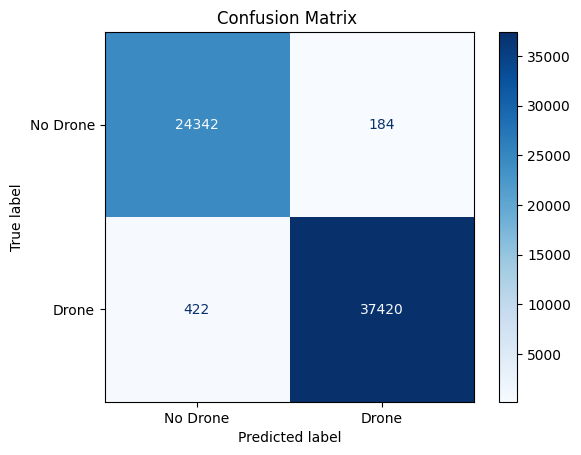


Classification Report:
              precision    recall  f1-score   support

    No Drone       0.98      0.99      0.99     24526
       Drone       1.00      0.99      0.99     37842

    accuracy                           0.99     62368
   macro avg       0.99      0.99      0.99     62368
weighted avg       0.99      0.99      0.99     62368



In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Convert probabilities into predicted labels using best threshold
y_pred = (probs >= best_thr).astype(int)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

# Plot with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Drone", "Drone"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title(f"Confusion Matrix ")
plt.show()

# Extra: precision, recall, F1 per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["No Drone", "Drone"]))
